In [1]:
%run '/home/gvolta/Desktop/Function/Useful/Def.ipynb'
%matplotlib inline

Initialization done, Notebook was last run on: 21/05/2019


In [2]:
import hax
hax.init(experiment='XENON1T',
         pax_version_policy = 'v6.10.1',
         main_data_paths= ['/dali/lgrandi/xenon1t/processed/pax_v6.10.1'], 
         minitree_paths = ['/dali/lgrandi/giovo/minitrees/pax_v6.10.1',
                           '/dali/lgrandi/xenon1t/minitrees/pax_v6.10.1'],
         make_minitrees = False)

In [3]:
Data = pd.read_pickle('/dali/lgrandi/giovo/minitrees/pax_v6.10.1/SR2_dataNG_post18836_after_selection_cs2_aft_nn_tf_pax6.10.1.pkl')
Data = Data.sort_values(by = ['s2'], ascending=True).reset_index(drop = True)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


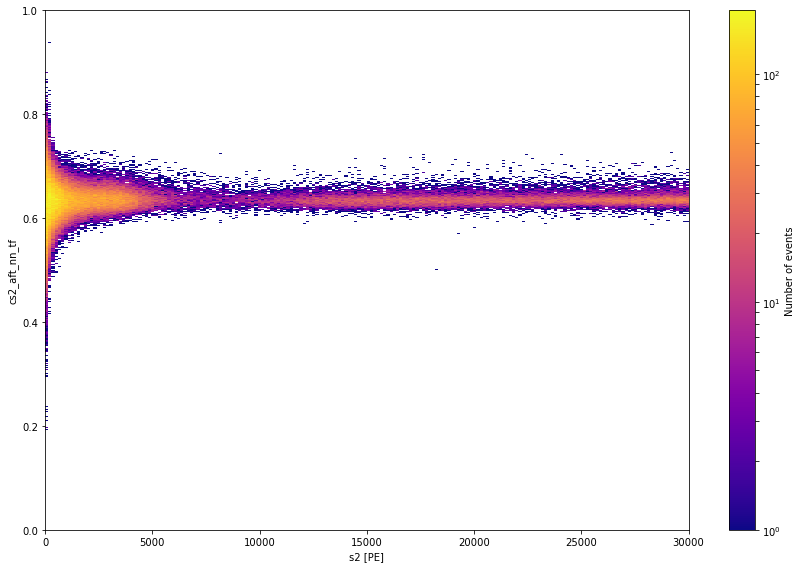

In [4]:
fig = plt.figure(1, figsize=(12,8))

plt.hist2d(Data['s2'], 
           Data['cs2_aft_nn_tf'],
           bins=(200,1000), 
           range=((0, 3e4), (0.0,1.0)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')

plt.tight_layout()

## S2PatternLikelihood

S2PatternLikelihood cut can remove unwanted events by comparing top PMT hit pattern and S2 LCE map for the reconstructed position, such as poorly reconstructed events, gas events etc.

In [5]:
def S2patternLikelihood(data):
    tmp = data
    a, b, c, d = -0.26768092, 1.92399006, 0.81202635, 107.85973175
    e, f = 7.41263054e-02, 9.62861121e+01
    y = (a*tmp['s2']+b*tmp['s2']**c+d)*(tmp['s2']<1e4) + (e*tmp['s2']+f)*(tmp['s2']>=1e4)
    return y

In [6]:
Data['S2patternLikelihood'] = S2patternLikelihood(Data)

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


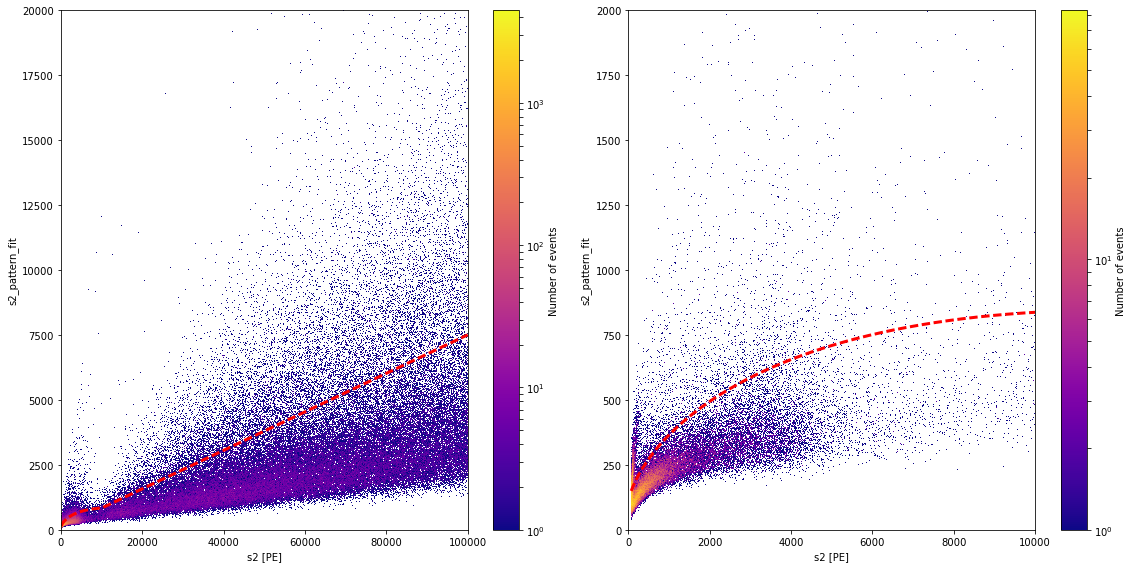

In [7]:
fig = plt.figure(1, figsize=(16,8))
plt.subplot(121)
plt.plot(Data['s2'][:1768064], Data['S2patternLikelihood'][:1768064], #1768064-> 2.16e6
         linestyle='--', linewidth=3.0, color='red')

plt.hist2d(Data['s2'], 
           Data['s2_pattern_fit'],
           bins=(1000,1000), 
           range=((0, 1e5), (0.0,2e4)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s2 [PE]')
plt.ylabel('s2_pattern_fit')

plt.subplot(122)
plt.plot(Data['s2'][:164321], Data['S2patternLikelihood'][:164321], #164321->1e4
         linestyle='--', linewidth=3.0, color='red')

plt.hist2d(Data['s2'], 
           Data['s2_pattern_fit'],
           bins=(1000,1000), 
           range=((0, 1e4), (0.0,2e3)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s2 [PE]')
plt.ylabel('s2_pattern_fit')
plt.tight_layout()

In [8]:
a, b, c, d = -0.26768092, 1.92399006, 0.81202635, 107.85973175
e, f = 7.41263054e-02, 9.62861121e+01
Data['CutS2patternLikelihood'] = ((Data['s2_pattern_fit'] < a*Data['s2']+b*Data['s2']**c+d) & (Data['s2'] < 1e4))|\
                                 ((Data['s2_pattern_fit'] < e*Data['s2']+f) & (Data['s2'] >= 1e4))
Data = hax.cuts.selection(Data, Data['CutS2patternLikelihood'] == True)

Unnamed selection: 308039 rows removed (83.07% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


# Dominick cut

In [9]:
def poly5(x, p0, p1, p2, p3, p4, p5):
    return p0 + p1 * x + p2 * x**2 + p3 * x**3 + p4 * x**4 + p5 * x**5

def inv_poly(x, p0, p1):
    return p0 / np.sqrt(x) + p1 / x

def fit_func(x, p0, p1, p2, p3, p4, p5, p6, p7):
    return poly5(x, p0, p1, p2, p3, p4, p5) + inv_poly(x, p6, p7)

top_params = [6.444777E-01, 2.839406E-07, -8.144186E-13, 9.594640E-19, -5.048081E-25, 9.800551E-32, 2.137005E+00, -5.703052E+00]
bot_params = [6.062605E-01, 6.560112E-08, -3.096827E-13, 4.119008E-19, -2.281155E-25, 4.613043E-32, -8.316705E-01, -1.075382E+01]

top_params_post = [6.533946E-01, 2.238536E-07, -5.791706E-13, 6.021542E-19, -2.786815E-25, 4.763021E-32, 2.021210E+00, -6.431296E+00]
bot_params_post = [6.228859E-01, 1.533585E-08, -2.468763E-13, 3.554834E-19, -1.932773E-25, 3.686730E-32, -1.675048E+00, -1.291028E-01]

top_params_pre = [6.275216E-01, 3.764326E-07, -1.341946E-12, 1.966495E-18, -1.273836E-24, 3.033794E-31, 2.720699E+00, -1.062852E+01]
bot_params_pre = [6.207396E-01, -2.494075E-08, -7.370097E-14, 1.850084E-19, -1.496903E-25, 4.060788E-32, -1.973666E+00, 2.273230E+00]


In [10]:
s2 = Data['s2']
cs2_aft_nn_tf = Data['cs2_aft_nn_tf']
run_number = Data['run_number']

In [11]:
cs2_aft_top_1 = (cs2_aft_nn_tf < fit_func(s2, *top_params)) | (s2 > 1888500.0) | (s2 < 90.0)
cs2_aft_bot_1 = (cs2_aft_nn_tf > fit_func(s2, *bot_params)) | (s2 > 1888500.0) | (s2 < 90.0)
cs2_aft_cut_1 = cs2_aft_top_1 & cs2_aft_bot_1

cs2_aft_top_post = (cs2_aft_nn_tf < fit_func(s2, *top_params_post)) | (s2 > 2163000.0) | (s2 < 60.0)
cs2_aft_bot_post = (cs2_aft_nn_tf > fit_func(s2, *bot_params_post)) | (s2 > 2163000.0) | (s2 < 60.0)

cs2_aft_top_pre = (cs2_aft_nn_tf < fit_func(s2, *top_params_pre)) | (s2 > 1515000.0) | (s2 < 60.0)
cs2_aft_bot_pre = (cs2_aft_nn_tf > fit_func(s2, *bot_params_pre)) | (s2 > 1515000.0) | (s2 < 60.0)

cs2_aft_top_2 = ((run_number < 18836) & cs2_aft_top_pre) | ((run_number >= 18836) & cs2_aft_top_post)
cs2_aft_bot_2 = ((run_number < 18836) & cs2_aft_bot_pre) | ((run_number >= 18836) & cs2_aft_bot_post)
cs2_aft_cut_2 = cs2_aft_top_2 & cs2_aft_bot_2

In [12]:
Data['cs2_aft_cut_1'] = cs2_aft_cut_1
Data['cs2_aft_cut_2'] = cs2_aft_cut_2
Data['cs2_aft_top_2'] = cs2_aft_top_2
Data['cs2_aft_bot_2'] = cs2_aft_bot_2

In [13]:
cut_1 = Data.copy()
cut_1 = hax.cuts.selection(cut_1, cut_1['cs2_aft_cut_1'] == True)
print(len(cut_1),len(Data),len(cut_1)/len(Data)) 

Unnamed selection: 8738 rows removed (99.42% passed)
1503075 1511813 0.9942201846392378


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [14]:
cut_2 = Data.copy()
cut_2 = hax.cuts.selection(cut_2, cut_2['cs2_aft_cut_2'] == True)

df = hax.cuts.history(cut_2)
print(hax.misc.dataframe_to_wiki(df, title="Table 1: cuts applied in my analysis"))

Unnamed selection: 9162 rows removed (99.39% passed)
^ Table 1: cuts applied in my analysis ^^^^^^
^ selection_desc ^ n_before ^ n_after ^ n_removed ^ fraction_passed ^ cumulative_fraction_left ^
| Unnamed | 1511813 | 1502651 | 9162 | 0.99394 | 0.99394 |



/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [15]:
tmp_cut = Data.copy()
tmp_cut = hax.cuts.selection(tmp_cut, tmp_cut['cs2_aft_top_2'] == True)
df = hax.cuts.history(tmp_cut)
print(hax.misc.dataframe_to_wiki(df, title="Table 1: cuts applied in my analysis"))

Unnamed selection: 3702 rows removed (99.76% passed)
^ Table 1: cuts applied in my analysis ^^^^^^
^ selection_desc ^ n_before ^ n_after ^ n_removed ^ fraction_passed ^ cumulative_fraction_left ^
| Unnamed | 1511813 | 1508111 | 3702 | 0.99755 | 0.99755 |



/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [16]:
temp_cut = Data.copy()
temp_cut = hax.cuts.selection(temp_cut, temp_cut['cs2_aft_bot_2'] == True)
df = hax.cuts.history(tmp_cut)
print(hax.misc.dataframe_to_wiki(df, title="Table 1: cuts applied in my analysis"))

Unnamed selection: 5460 rows removed (99.64% passed)
^ Table 1: cuts applied in my analysis ^^^^^^
^ selection_desc ^ n_before ^ n_after ^ n_removed ^ fraction_passed ^ cumulative_fraction_left ^
| Unnamed | 1511813 | 1508111 | 3702 | 0.99755 | 0.99755 |



/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [17]:
s2 = s2.sort_values(ascending = True).reset_index(drop = True)
cs2_aft_top_1 = fit_func(s2, *top_params)
cs2_aft_bot_1 = fit_func(s2, *bot_params)

In [18]:
toDF_cs2_aft_top_2 = fit_func(s2, *top_params_pre)*(run_number < 18836) + \
                     fit_func(s2, *top_params_post)*(run_number >= 18836)
toDF_cs2_aft_top_2 = toDF_cs2_aft_top_2.rename('cs2_aft_top_2')
DF_cs2_aft_top_2 = pd.concat([s2, toDF_cs2_aft_top_2], axis=1)
DF_cs2_aft_top_2['NaN'] = DF_cs2_aft_top_2['cs2_aft_top_2'].isnull()
DF_cs2_aft_top_2 = hax.cuts.selection(DF_cs2_aft_top_2, DF_cs2_aft_top_2['NaN'] == False)

toDF_cs2_aft_bot_2 = fit_func(s2, *bot_params_pre)*(run_number < 18836) + \
                     fit_func(s2, *bot_params_post)*(run_number >= 18836)
toDF_cs2_aft_bot_2 = toDF_cs2_aft_bot_2.rename('cs2_aft_bot_2')
DF_cs2_aft_bot_2 = pd.concat([s2, toDF_cs2_aft_bot_2], axis=1)
DF_cs2_aft_bot_2['NaN'] = DF_cs2_aft_bot_2['cs2_aft_bot_2'].isnull()
DF_cs2_aft_bot_2 = hax.cuts.selection(DF_cs2_aft_bot_2, DF_cs2_aft_bot_2['NaN'] == False)

Unnamed selection: 503284 rows removed (71.46% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 503284 rows removed (71.46% passed)


# Old cut

## New cut

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


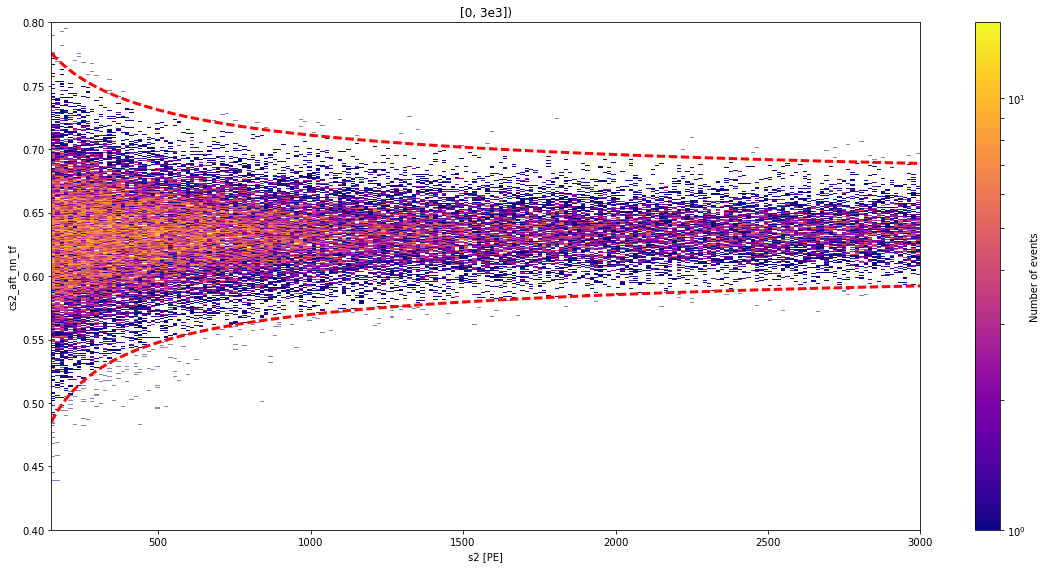

In [19]:
fig = plt.figure(4, figsize=(16,8))
hist, xbins, ybins, _ = plt.hist2d(Data['s2'], 
                                   Data['cs2_aft_nn_tf'], 
                                   bins=(200,1000), 
                                   range=((150, 3e3), (0.4,0.8)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 0.5)
#plt.colorbar(label='Number of events')
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(cut_2['s2'], 
                                               cut_2['cs2_aft_nn_tf'],
                                               bins=(200,1000), 
                                               range=((150, 3e3), (0.4,0.8)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                               cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.plot(DF_cs2_aft_top_2.s2.iloc[10:], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:], 
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')

plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')
plt.title('[0, 3e3])')

plt.tight_layout()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [20]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_centers_acceptance.append((xbins_cut[i+1] + xbins_cut[i])/2.)
    acceptance.append(hist_cut[i].sum()/hist[i].sum())
    sigma.append(np.sqrt(acceptance[i]*(1-acceptance[i])/hist[i].sum()))

bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
acceptance = acceptance[np.logical_not(np.isnan(acceptance))]
sigma = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance)
acceptance_median = np.median(acceptance)

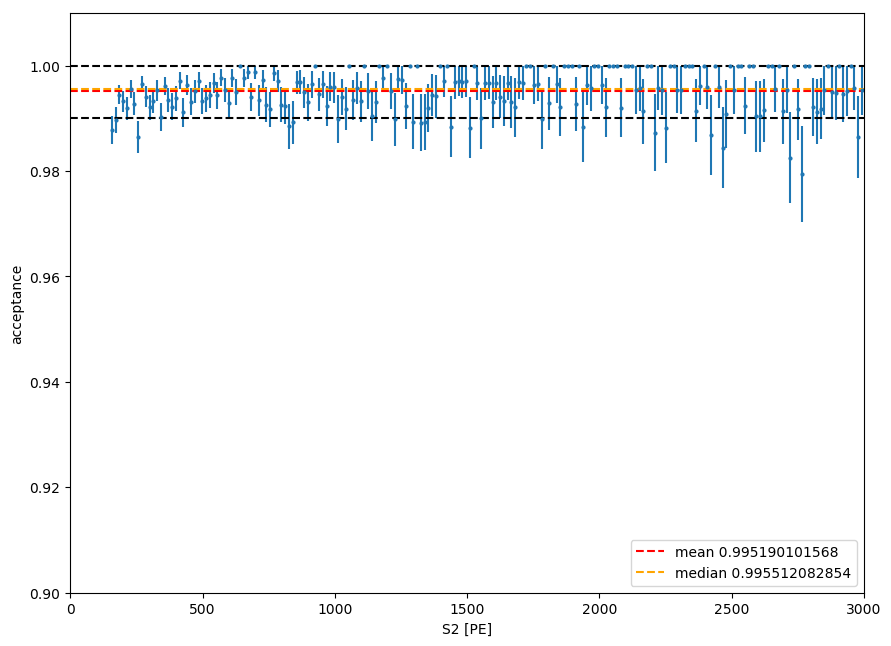

In [21]:
plt.figure(figsize=(10.24, 7.68), dpi=100)

plt.errorbar(bin_centers_acceptance, acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=1, xmin=0, xmax=3e3, linestyle = '--')
plt.hlines(y=0.99, xmin=0, xmax=3e3, linestyle = '--')
plt.hlines(y=acceptance_mean, xmin=0, xmax=3e3, linestyle = '--', label='mean '+str(acceptance_mean), color = 'red')
plt.hlines(y=acceptance_median, xmin=0, xmax=3e3, linestyle = '--', label='median '+str(acceptance_median), color = 'orange')
plt.legend(loc='lower right')
plt.xlim(0, 3e3)
plt.ylim(0.90, 1.01)
plt.xlabel('S2 [PE]')
plt.ylabel('acceptance')

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


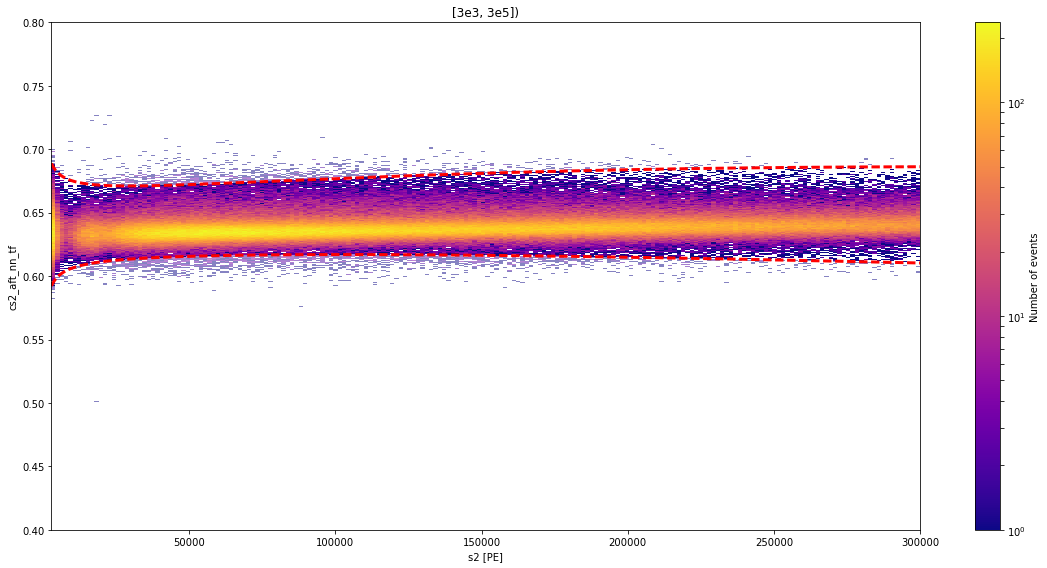

In [22]:
fig = plt.figure(5, figsize=(16,8))
hist, xbins, ybins, _ = plt.hist2d(Data['s2'], 
                                   Data['cs2_aft_nn_tf'], 
                                   bins=(200,1000), 
                                   range=((3e3, 3e5), (0.4,0.8)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 0.5)
#plt.colorbar(label='Number of events')
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(cut_2['s2'], 
                                               cut_2['cs2_aft_nn_tf'],
                                               bins=(200,1000), 
                                               range=((3e3, 3e5), (0.4,0.8)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                               cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.plot(DF_cs2_aft_top_2.s2.iloc[10:], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')

plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')
plt.title('[3e3, 3e5])')

plt.tight_layout()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [23]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    bin_centers_acceptance.append((xbins_cut[i+1] + xbins_cut[i])/2.)
    acceptance.append(hist_cut[i].sum()/hist[i].sum())
    sigma.append(np.sqrt(acceptance[i]*(1-acceptance[i])/hist[i].sum()))

bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
acceptance = acceptance[np.logical_not(np.isnan(acceptance))]
sigma = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance)
acceptance_median = np.median(acceptance)

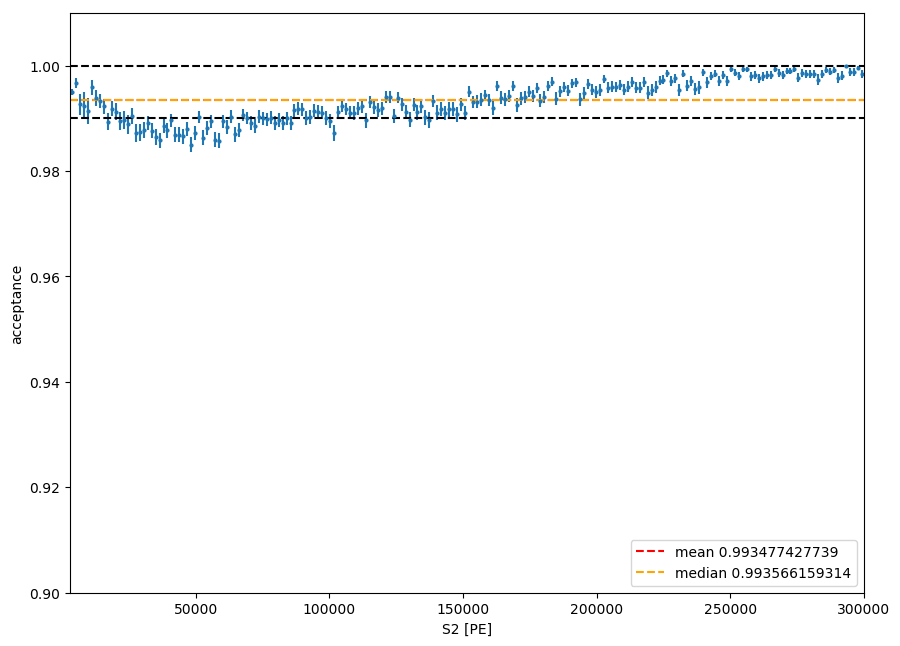

In [24]:
plt.figure(figsize=(10.24, 7.68), dpi=100)

plt.errorbar(bin_centers_acceptance[:], acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=1, xmin=3e3, xmax=3e5, linestyle = '--')
plt.hlines(y=0.99, xmin=3e3, xmax=3e5, linestyle = '--')
plt.hlines(y=acceptance_mean, xmin=3e3, xmax=3e5, linestyle = '--', label='mean ' + str(acceptance_mean), color = 'red')
plt.hlines(y=acceptance_median, xmin=3e3, xmax=3e5, linestyle = '--', label='median ' + str(acceptance_median), color = 'orange')
plt.legend(loc='lower right')
plt.xlim(3e3, 3e5)
plt.ylim(0.90, 1.01)
plt.xlabel('S2 [PE]')
plt.ylabel('acceptance')

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


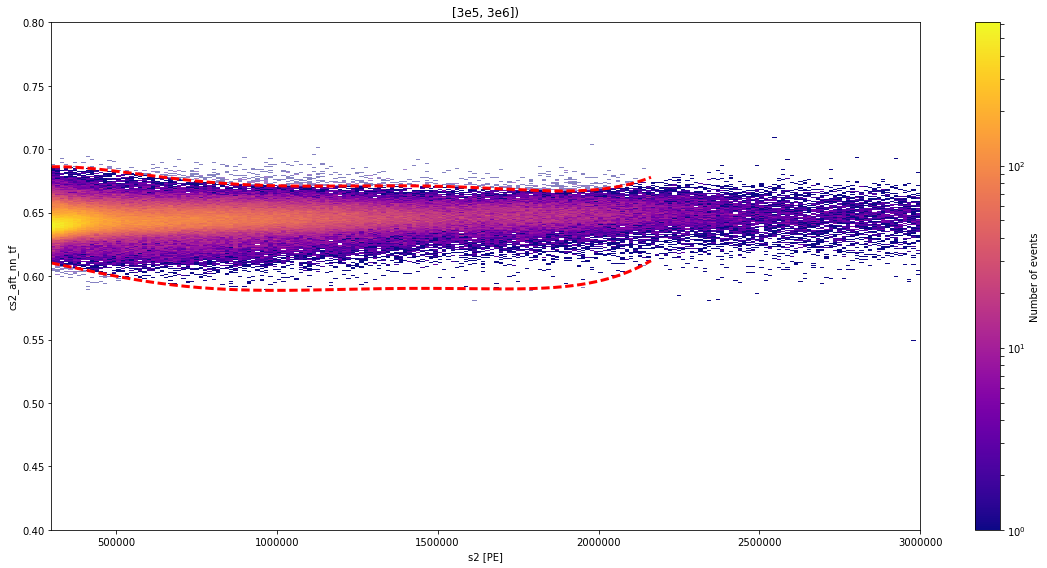

In [25]:
fig = plt.figure(6, figsize=(16,8))
hist, xbins, ybins, _ = plt.hist2d(Data['s2'], 
                                   Data['cs2_aft_nn_tf'], 
                                   bins=(200,1000), 
                                   range=((3e5, 3e6), (0.4,0.8)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 0.5)
#plt.colorbar(label='Number of events')
hist_cut, xbins_cut, ybins_cut, _ = plt.hist2d(cut_2['s2'], 
                                               cut_2['cs2_aft_nn_tf'],
                                               bins=(200,1000), 
                                               range=((3e5, 3e6), (0.4,0.8)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                               cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.plot(DF_cs2_aft_top_2.s2.iloc[10:1230673], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:1230673],
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:1230673], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:1230673],
         linestyle='--', linewidth=3.0, color='red')

plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')
plt.title('[3e5, 3e6])')

plt.tight_layout()
hist[np.isnan(hist)] = 0
hist_cut[np.isnan(hist_cut)] = 0

In [26]:
DF_cs2_aft_top_2.s2.iloc[1230673] #1768064->2163000 without S2pattern, 1230674->2163000 with S2pattern

2162864.5

In [27]:
len(DF_cs2_aft_top_2)

1260171

In [28]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut)-1):
    if(xbins_cut[i] <= 2163000):
        bin_centers_acceptance.append((xbins_cut[i+1] + xbins_cut[i])/2.)
        acceptance.append(hist_cut[i].sum()/hist[i].sum())
        sigma.append(np.sqrt(acceptance[i]*(1-acceptance[i])/hist[i].sum()))
        
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
acceptance = acceptance[np.logical_not(np.isnan(acceptance))]
sigma = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance)
acceptance_median = np.median(acceptance)

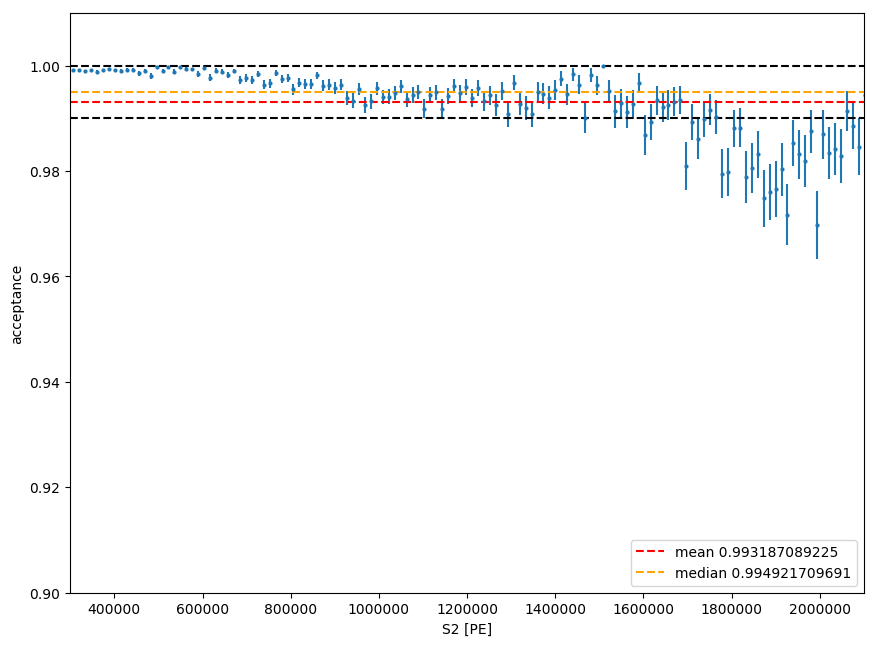

In [29]:
plt.figure(figsize=(10.24, 7.68), dpi=100)

plt.errorbar(bin_centers_acceptance[:], acceptance, yerr=sigma, linestyle = ' ', marker= 'o', markersize = 2)
plt.hlines(y=1, xmin=3e5, xmax=2.1e6, linestyle = '--')
plt.hlines(y=0.99, xmin=3e5, xmax=2.1e6, linestyle = '--')
plt.hlines(y=acceptance_mean, xmin=3e5, xmax=2.1e6, linestyle = '--', label='mean ' + str(acceptance_mean), color = 'red')
plt.hlines(y=acceptance_median, xmin=3e5, xmax=2.1e6, linestyle = '--', label='median ' + str(acceptance_median), color = 'orange')
plt.legend(loc='lower right')
plt.xlim(3e5, 2.1e6)
plt.ylim(0.90, 1.01)
plt.xlabel('S2 [PE]')
plt.ylabel('acceptance')

# Acceptance up to 10^4

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


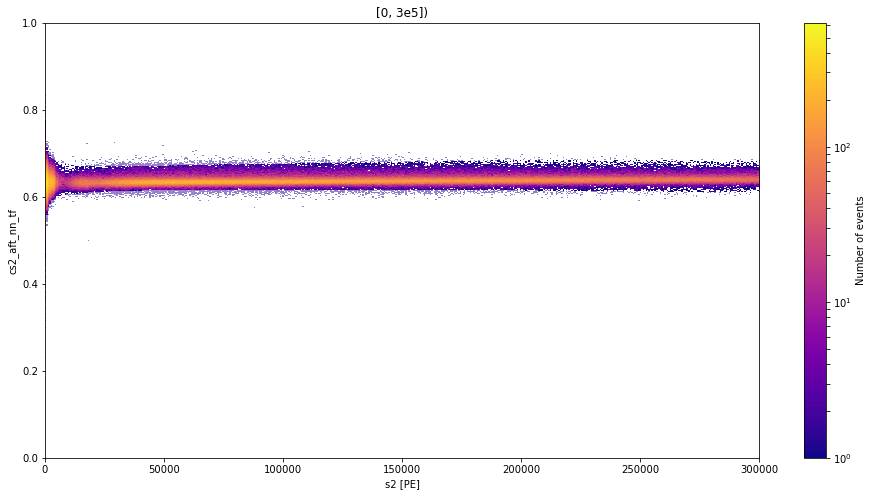

In [30]:
fig = plt.figure(6, figsize=(16,8))
hist, xbins, ybins, _ = plt.hist2d(Data['s2'], 
                                   Data['cs2_aft_nn_tf'], 
                                   bins=(500,1000), 
                                   range=((100, 3e5), (0.0,1.0)), 
                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                   cmin = 1,alpha = 0.5)

hist_cut_2, xbins_cut_2, ybins_cut_2, _ = plt.hist2d(cut_2['s2'], 
                                                     cut_2['cs2_aft_nn_tf'],
                                                     bins=(500,1000), 
                                                     range=((100, 3e5), (0.0,1.0)), 
                                                     cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                                     cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')
plt.title('[0, 3e5])')

hist[np.isnan(hist)] = 0
hist_cut_2[np.isnan(hist_cut_2)] = 0

In [31]:
bin_centers_acceptance = []
acceptance = []
sigma = []
for i in range(len(xbins_cut_2)-1):
        bin_centers_acceptance.append((xbins_cut_2[i+1] + xbins_cut_2[i])/2.)
        acceptance.append(hist_cut_2[i].sum()/hist[i].sum())
        sigma.append(np.sqrt(acceptance[i]*(1-acceptance[i])/hist[i].sum()))
        
bin_centers_acceptance = np.array(bin_centers_acceptance)
acceptance = np.array(acceptance)
sigma = np.array(sigma)
acceptance = acceptance[np.logical_not(np.isnan(acceptance))]
sigma = sigma[np.logical_not(np.isnan(sigma))]
acceptance_mean = np.mean(acceptance)
acceptance_median = np.median(acceptance)

In [32]:
tmp = np.array([bin_centers_acceptance, acceptance, sigma])
tmp = tmp.transpose()
Acceptance_2 = pd.DataFrame(tmp, 
                           columns=['bin_centers_acceptance', 'acceptance', 'sigma'])
Acceptance_2['NaN'] = Acceptance_2['sigma'].isnull()
Acceptance_2 = hax.cuts.selection(Acceptance_2, Acceptance_2['NaN'] == False)

Unnamed selection: 0 rows removed (100.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


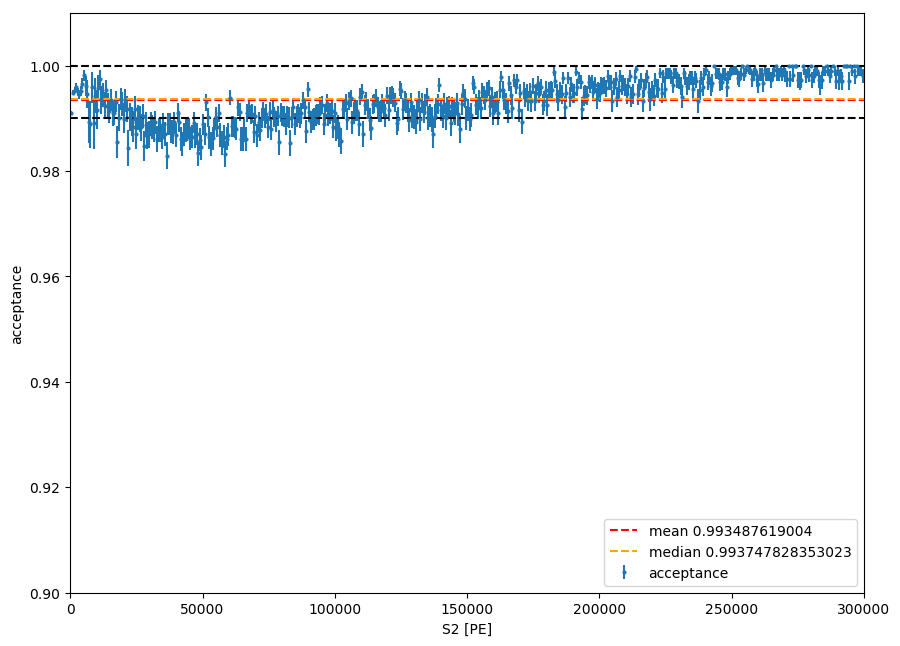

In [33]:
plt.figure(figsize=(10.24, 7.68), dpi=100)

plt.errorbar(Acceptance_2['bin_centers_acceptance'], Acceptance_2['acceptance'], yerr=Acceptance_2['sigma'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=0, xmax=3e5, linestyle = '--')
plt.hlines(y=0.99, xmin=0, xmax=3e5, linestyle = '--')
plt.hlines(y=Acceptance_2['acceptance'].mean(), xmin=0, xmax=3e5, linestyle = '--', 
           label='mean ' + str(Acceptance_2['acceptance'].mean()), color = 'red')
plt.hlines(y=Acceptance_2['acceptance'].median(), xmin=0, xmax=3e5, linestyle = '--', 
           label='median ' + str(Acceptance_2['acceptance'].median()), color = 'orange')
plt.legend(loc='lower right')
plt.xlim(0, 3e5)
plt.ylim(0.90, 1.01)
plt.xlabel('S2 [PE]')
plt.ylabel('acceptance')
#plt.xscale('log')

# Acceptance as a function of z and xy

In [34]:
cut_2['theta_3d_nn_tf'] = 2 * np.pi * np.arctan(cut_2['y_3d_nn_tf']/cut_2['x_3d_nn_tf'])
tmp = cut_2.copy()
z1 = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
z2 = tmp[(tmp['z_3d_nn_tf']>-60) & (tmp['z_3d_nn_tf']<=-30)]
z3 = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-60)] 

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


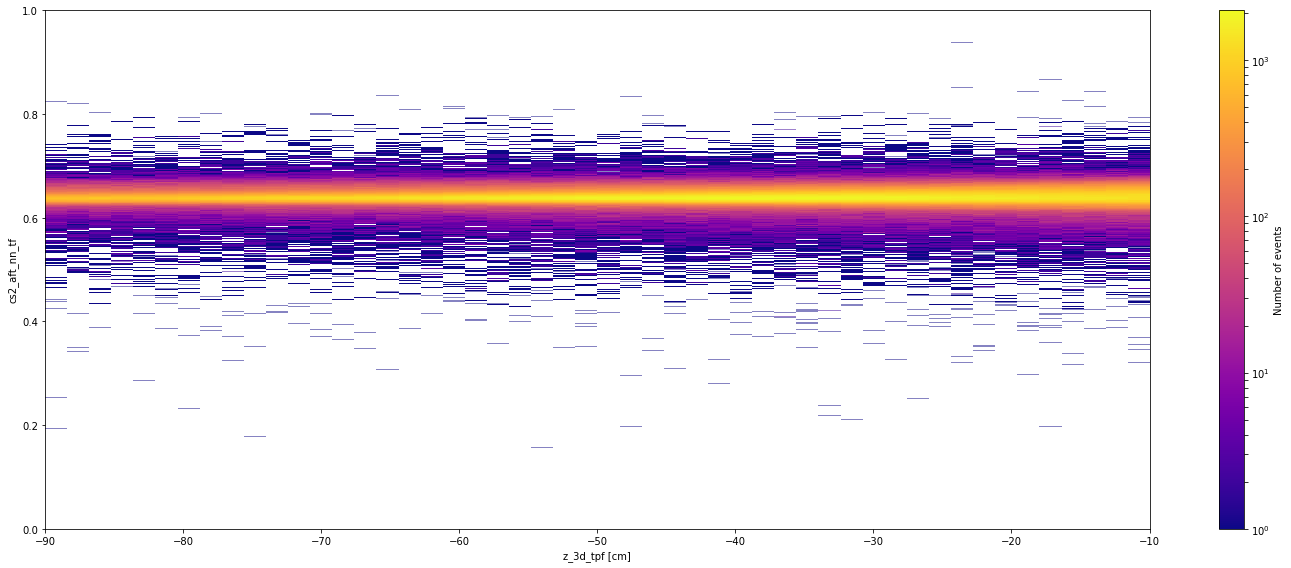

In [35]:
fig = plt.figure(figsize=(20,8))

hist_z, xbins_z, ybins_z, _ = plt.hist2d(Data['z_3d_tpf'], 
           Data['cs2_aft_nn_tf'],
           bins=(50,1000), 
           range=((-90, -10), (0.0,1.0)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 0.50)
#plt.colorbar(label='Number of events')

hist_z_cut, xbins_z_cut, ybins_z_cut, _ = plt.hist2d(cut_2['z_3d_tpf'], 
           cut_2['cs2_aft_nn_tf'], 
           bins=(50,1000), 
           range=((-90, -10), (0.0,1.0)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')

plt.xlabel('z_3d_tpf [cm]')
plt.ylabel('cs2_aft_nn_tf')

plt.tight_layout()

hist_z[np.isnan(hist_z)] = 0
hist_z_cut[np.isnan(hist_z_cut)] = 0

In [36]:
bin_centers_acceptance_z = []
acceptance_z = []
sigma_z = []
for i in range(len(xbins_z_cut)-1):
        bin_centers_acceptance_z.append((xbins_z_cut[i+1] + xbins_z_cut[i])/2.)
        acceptance_z.append(hist_z_cut[i].sum()/hist_z[i].sum())
        sigma_z.append(np.sqrt(acceptance_z[i]*(1-acceptance_z[i])/hist_z[i].sum()))
        
bin_centers_acceptance_z = np.array(bin_centers_acceptance_z)
acceptance_z = np.array(acceptance_z)
sigma_z = np.array(sigma_z)


In [37]:
tmp = np.array([bin_centers_acceptance_z, acceptance_z, sigma_z])
tmp = tmp.transpose()
Acceptance_z = pd.DataFrame(tmp, 
                            columns=['bin_centers_acceptance_z', 'acceptance_z', 'sigma_z'])
Acceptance_z['NaN'] = Acceptance_z['sigma_z'].isnull()
Acceptance_z = hax.cuts.selection(Acceptance_z, Acceptance_z['NaN'] == False)

Unnamed selection: 0 rows removed (100.00% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


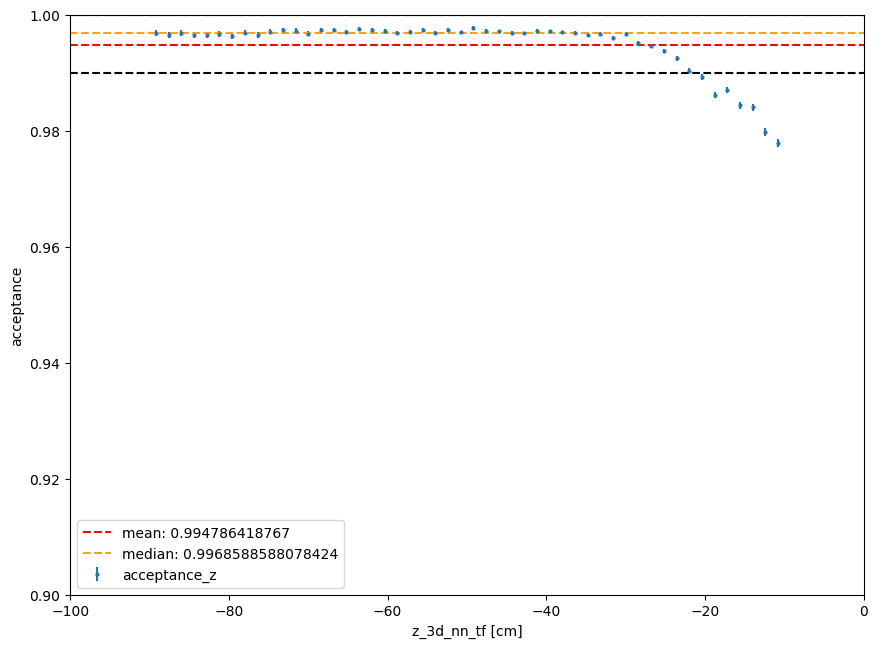

In [38]:
plt.figure(figsize=(10.24, 7.68), dpi=100)

plt.errorbar(Acceptance_z['bin_centers_acceptance_z'], Acceptance_z['acceptance_z'], yerr=Acceptance_z['sigma_z'], 
             linestyle = ' ', marker= 'o', markersize = 2)

plt.hlines(y=1, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=0.99, xmin=-100, xmax=0, linestyle = '--')
plt.hlines(y=Acceptance_z['acceptance_z'].mean(), xmin=-100, xmax=0, linestyle = '--', 
           label='mean: '+str(Acceptance_z['acceptance_z'].mean()), color = 'red')
plt.hlines(y=Acceptance_z['acceptance_z'].median(), xmin=-100, xmax=0, linestyle = '--', 
           label='median: '+str(Acceptance_z['acceptance_z'].median()), color = 'orange')
plt.legend(loc='lower left')
plt.xlim(-100, 0)
plt.ylim(0.90, 1.0)
plt.xlabel('z_3d_nn_tf [cm]')
plt.ylabel('acceptance')

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


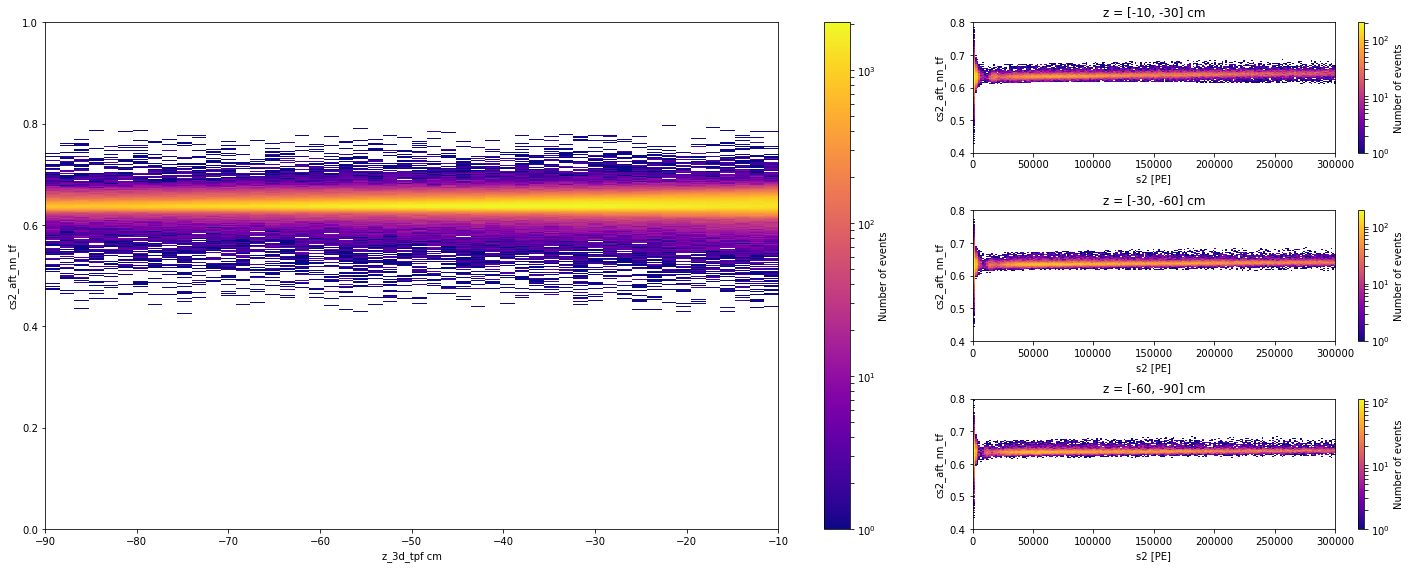

In [39]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20,8))
gs2 = GridSpec(3, 3)
#gs2.update(left=0.55, right=0.98, hspace=0.05)
ax1 = plt.subplot(gs2[:, :-1])
plt.hist2d(cut_2['z_3d_nn_tf'], 
           cut_2['cs2_aft_nn_tf'], 
           bins=(50,1000), 
           range=((-90, -10), (0,1)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1) 
plt.xlabel('z_3d_tpf cm')
plt.ylabel('cs2_aft_nn_tf')
plt.colorbar(label='Number of events')

ax2 = plt.subplot(gs2[0, -1])
plt.hist2d(z1['s2'], 
           z1['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')
plt.title('z = [-10, -30] cm')

ax3 = plt.subplot(gs2[1, -1])
plt.hist2d(z2['s2'], 
           z2['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')
plt.title('z = [-30, -60] cm')

ax4 = plt.subplot(gs2[-1, -1])
plt.hist2d(z3['s2'], 
           z3['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1)
plt.colorbar(label='Number of events')
plt.xlabel('s2 [PE]')
plt.ylabel('cs2_aft_nn_tf')
plt.title('z = [-60, -90] cm')


plt.tight_layout()

#hist_z[np.isnan(hist_z)] = 0
#hist_z_cut[np.isnan(hist_z_cut)] = 0

# XY acceptance

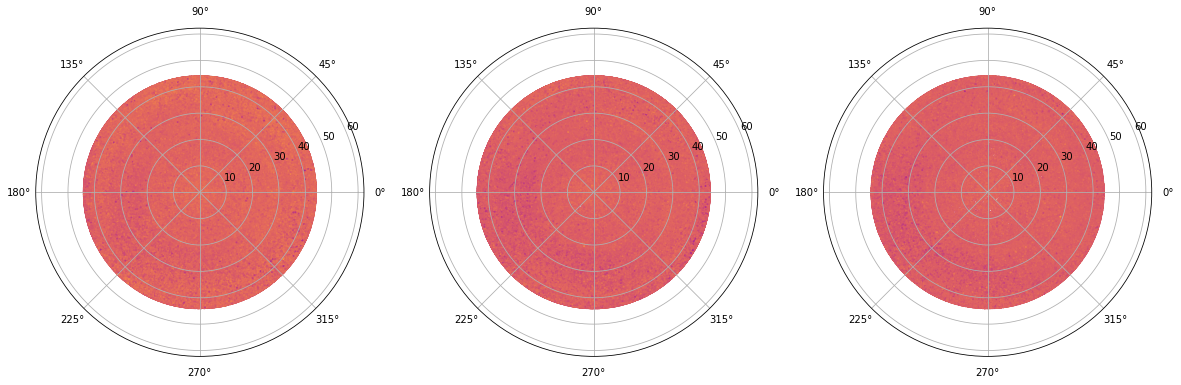

In [40]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(131, projection='polar')
c1 = ax1.scatter(z1['theta_3d_nn_tf'], z1['r_3d_nn_tf'], c=z1['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)
#ax1.title('z = [-10, -30] cm')
ax2 = fig.add_subplot(132, projection='polar')
c2 = ax2.scatter(z2['theta_3d_nn_tf'], z2['r_3d_nn_tf'], c=z2['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)
#ax2.title('z = [-30, -60] cm')
ax3 = fig.add_subplot(133, projection='polar')
c3 = ax3.scatter(z3['theta_3d_nn_tf'], z3['r_3d_nn_tf'], c=z3['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)
#ax3.title('z = [-60, -90] cm')

In [41]:
Data

,alt_s1_interaction_drift_time,alt_s1_interaction_z,alt_s1_tight_coincidence,alt_s2_interaction_s2_range_50p_area,alt_s2_interaction_s2_range_80p_area,alt_s2_interaction_x,alt_s2_interaction_y,alt_s2_interaction_z,cs1,cs1_nn,...,Cut_z_3d_nn_tf,Cut_s2_range_50p_area,cs2_aft_nn_tf,Cut_bias_sr2,S2patternLikelihood,CutS2patternLikelihood,cs2_aft_cut_1,cs2_aft_cut_2,cs2_aft_top_2,cs2_aft_bot_2
0,422780.0,-56.109798,2.0,NaN,NaN,NaN,NaN,NaN,1372.187657,1355.723441,...,True,True,0.659108,True,149.726351,True,True,True,True,True
1,927490.0,-123.362221,2.0,NaN,NaN,NaN,NaN,NaN,1422.628974,1421.182016,...,True,True,0.850446,True,149.728108,True,True,False,False,True
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.814058,2.914431,...,True,True,0.600606,True,149.728221,True,True,True,True,True
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.169273,1.190428,...,True,True,0.674409,True,149.730027,True,True,True,True,True
5,248990.0,-32.951740,2.0,NaN,NaN,NaN,NaN,NaN,2.574554,2.546483,...,True,True,0.687874,True,149.730688,True,True,True,True,True
7,793440.0,-105.499283,4.0,NaN,NaN,NaN,NaN,NaN,15.860869,15.820769,...,True,True,0.649053,True,149.732089,True,True,True,True,True
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.702174,2.756273,...,True,True,0.552495,True,149.733737,True,True,True,True,True
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.149633,11.205888,...,True,True,0.556326,True,149.734626,True,True,True,True,True
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.477704,2.476892,...,True,True,0.546674,True,149.736994,True,True,True,True,True
11,381640.0,-50.626999,2.0,NaN,NaN,NaN,NaN,NaN,2.470058,2.473002,...,True,True,0.748522,True,149.739109,True,True,True,True,True


### Checking xy position of cutted events

In [42]:
check_xy = Data.copy()
check_xy = hax.cuts.selection(check_xy, check_xy['cs2_aft_cut_2'] == False)

Unnamed selection: 1502651 rows removed (0.61% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


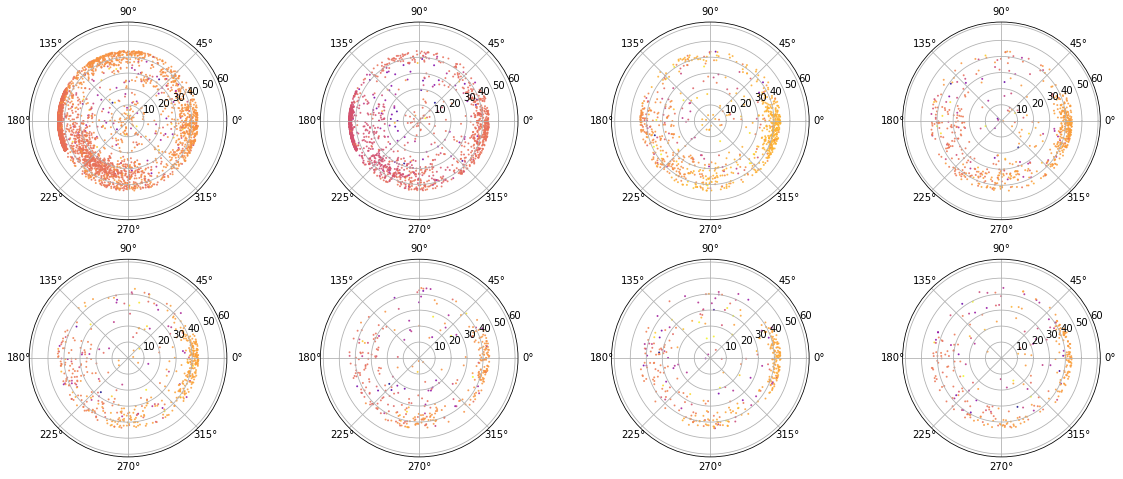

In [43]:
check_xy['theta_3d_nn_tf'] = 2 * np.pi * np.arctan(check_xy['y_3d_nn_tf']/check_xy['x_3d_nn_tf'])
z1_xy = check_xy[(check_xy['z_3d_nn_tf']>-20) & (check_xy['z_3d_nn_tf']<=-10)]
z2_xy = check_xy[(check_xy['z_3d_nn_tf']>-30) & (check_xy['z_3d_nn_tf']<=-20)]
z3_xy = check_xy[(check_xy['z_3d_nn_tf']>-40) & (check_xy['z_3d_nn_tf']<=-30)] 
z4_xy = check_xy[(check_xy['z_3d_nn_tf']>-50) & (check_xy['z_3d_nn_tf']<=-40)] 
z5_xy = check_xy[(check_xy['z_3d_nn_tf']>-60) & (check_xy['z_3d_nn_tf']<=-50)] 
z6_xy = check_xy[(check_xy['z_3d_nn_tf']>-70) & (check_xy['z_3d_nn_tf']<=-60)] 
z7_xy = check_xy[(check_xy['z_3d_nn_tf']>-80) & (check_xy['z_3d_nn_tf']<=-70)]
z8_xy = check_xy[(check_xy['z_3d_nn_tf']>-90) & (check_xy['z_3d_nn_tf']<=-80)]

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(241, projection='polar')
c1 = ax1.scatter(z1_xy['theta_3d_nn_tf'], z1_xy['r_3d_nn_tf'], c=z1_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

ax2 = fig.add_subplot(242, projection='polar')
c2 = ax2.scatter(z2_xy['theta_3d_nn_tf'], z2_xy['r_3d_nn_tf'], c=z2_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

ax3 = fig.add_subplot(243, projection='polar')
c3 = ax3.scatter(z3_xy['theta_3d_nn_tf'], z3_xy['r_3d_nn_tf'], c=z3_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

ax4 = fig.add_subplot(244, projection='polar')
c4 = ax4.scatter(z4_xy['theta_3d_nn_tf'], z4_xy['r_3d_nn_tf'], c=z4_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

ax5 = fig.add_subplot(245, projection='polar')
c5 = ax5.scatter(z5_xy['theta_3d_nn_tf'], z5_xy['r_3d_nn_tf'], c=z5_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

ax6 = fig.add_subplot(246, projection='polar')
c6 = ax6.scatter(z6_xy['theta_3d_nn_tf'], z6_xy['r_3d_nn_tf'], c=z6_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

ax7 = fig.add_subplot(247, projection='polar')
c7 = ax7.scatter(z7_xy['theta_3d_nn_tf'], z7_xy['r_3d_nn_tf'], c=z7_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

ax8 = fig.add_subplot(248, projection='polar')
c8 = ax8.scatter(z8_xy['theta_3d_nn_tf'], z8_xy['r_3d_nn_tf'], c=z8_xy['cs2_aft_nn_tf'], s=1, cmap='plasma', alpha=0.75)

## Acceptance xy

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


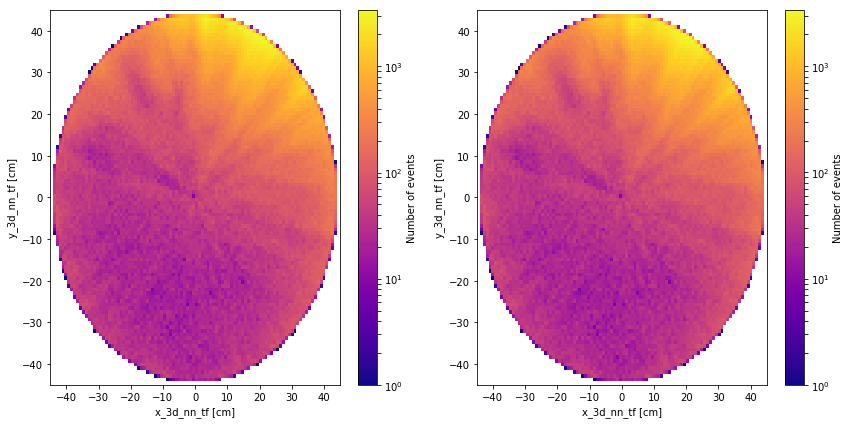

In [44]:
plt.figure(figsize=(12,6))
plt.subplot(121)
hist_data, x_data, y_data, image_data = plt.hist2d(Data['x_3d_nn_tf'], 
                                                   Data['y_3d_nn_tf'], 
                                                   bins=(100,100), 
                                                   range=((-45, +45), (-45, +45)), 
                                                   cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                                   cmin = 1,alpha = 1) 
plt.xlabel('x_3d_nn_tf [cm]')
plt.ylabel('y_3d_nn_tf [cm]')
plt.colorbar(label='Number of events')

plt.subplot(122)
hist_cut, x_cut, y_cut, image_cut = plt.hist2d(cut_2['x_3d_nn_tf'], 
                                               cut_2['y_3d_nn_tf'], 
                                               bins=(100,100), 
                                               range=((-45, +45), (-45, +45)), 
                                               cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
                                               cmin = 1,alpha = 1) 
plt.xlabel('x_3d_nn_tf [cm]')
plt.ylabel('y_3d_nn_tf [cm]')
plt.colorbar(label='Number of events')
plt.tight_layout()

Acceptance_xy = hist_cut/hist_data

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


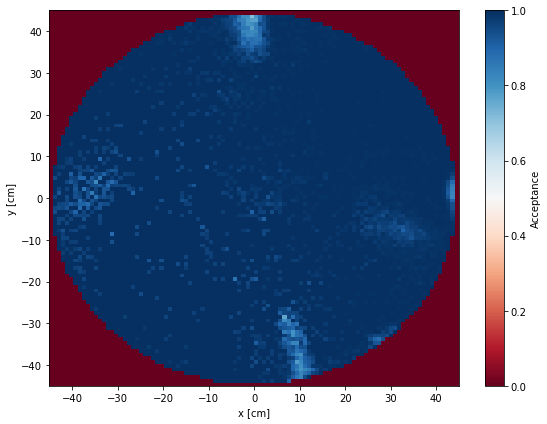

In [45]:
plt.figure(figsize=(8,6))
c = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

### Last check

In [46]:
tmp = Data.copy()
xy_z1 = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10)]
xy_z2 = tmp[(tmp['z_3d_nn_tf']>-60) & (tmp['z_3d_nn_tf']<=-30)]
xy_z3 = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-60)] 

xy_z1_cut = hax.cuts.selection(xy_z1, xy_z1['cs2_aft_cut_2'] == True)
xy_z2_cut = hax.cuts.selection(xy_z2, xy_z2['cs2_aft_cut_2'] == True)
xy_z3_cut = hax.cuts.selection(xy_z3, xy_z3['cs2_aft_cut_2'] == True)

Unnamed selection: 6156 rows removed (98.81% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 1987 rows removed (99.70% passed)
Unnamed selection: 1019 rows removed (99.70% passed)


### [-10;-30] cm

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


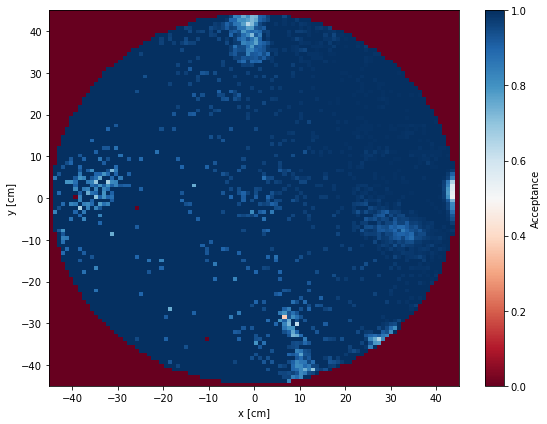

In [47]:
hist_data, x_data, y_data = np.histogram2d(xy_z1['x_3d_nn_tf'], xy_z1['y_3d_nn_tf'], 
                                           bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut, x_cut, y_cut = np.histogram2d(xy_z1_cut['x_3d_nn_tf'], xy_z1_cut['y_3d_nn_tf'], 
                                        bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy = hist_cut/hist_data
plt.figure(figsize=(8,6))
c1 = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

### [-30;-60] cm

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


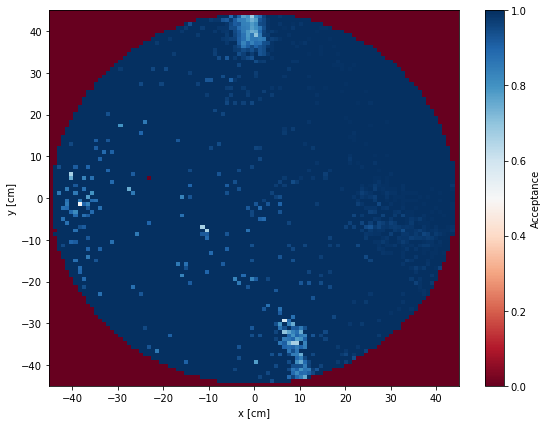

In [48]:
hist_data, x_data, y_data = np.histogram2d(xy_z2['x_3d_nn_tf'], xy_z2['y_3d_nn_tf'], 
                                           bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut, x_cut, y_cut = np.histogram2d(xy_z2_cut['x_3d_nn_tf'], xy_z2_cut['y_3d_nn_tf'], 
                                        bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy = hist_cut/hist_data
plt.figure(figsize=(8,6))
c2 = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c2, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

### [-60;-90] cm

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


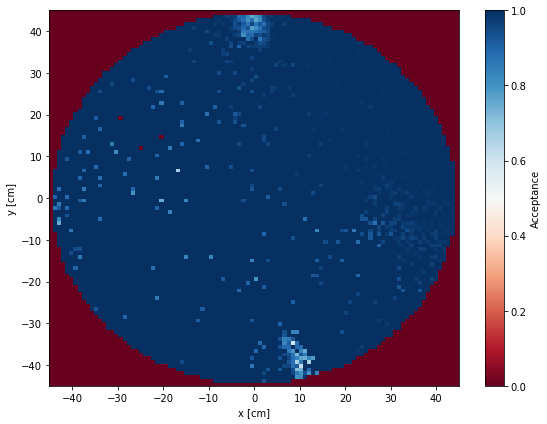

In [49]:
hist_data, x_data, y_data = np.histogram2d(xy_z3['x_3d_nn_tf'], xy_z3['y_3d_nn_tf'], 
                                           bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut, x_cut, y_cut = np.histogram2d(xy_z3_cut['x_3d_nn_tf'], xy_z3_cut['y_3d_nn_tf'], 
                                        bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy = hist_cut/hist_data
plt.figure(figsize=(8,6))
c3 = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c3, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

### Last last check

In [101]:
tmp = Data.copy()
tmp = tmp[tmp['s2']<2163000]
xy_z1_energy = tmp[(tmp['z_3d_nn_tf']>-30) & (tmp['z_3d_nn_tf']<=-10) & ((tmp['s2']<1e5))] #(tmp['s2']<1e4) |
xy_z2_energy = tmp[(tmp['z_3d_nn_tf']>-60) & (tmp['z_3d_nn_tf']<=-30) & ((tmp['s2']<1e5))] #(tmp['s2']<1e4) | 
xy_z3_energy = tmp[(tmp['z_3d_nn_tf']>-90) & (tmp['z_3d_nn_tf']<=-60) & ((tmp['s2']<1e5))] #(tmp['s2']<1e4) | 

xy_z1_energy_cut = hax.cuts.selection(xy_z1_energy, xy_z1_energy['cs2_aft_cut_2'] == True)
xy_z2_energy_cut = hax.cuts.selection(xy_z2_energy, xy_z2_energy['cs2_aft_cut_2'] == True)
xy_z3_energy_cut = hax.cuts.selection(xy_z3_energy, xy_z3_energy['cs2_aft_cut_2'] == True)

Unnamed selection: 3136 rows removed (98.19% passed)
Unnamed selection: 1134 rows removed (99.43% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


Unnamed selection: 653 rows removed (99.44% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


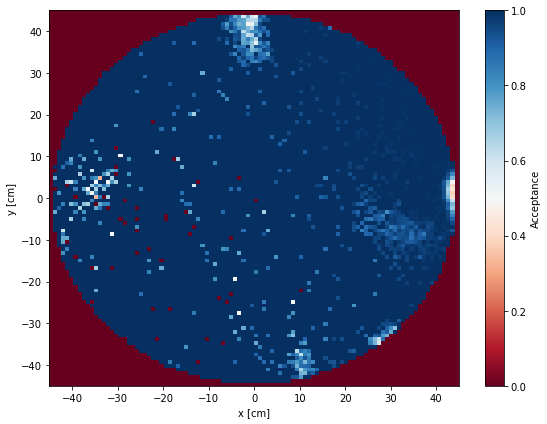

In [102]:
hist_data, x_data, y_data = np.histogram2d(xy_z1_energy['x_3d_nn_tf'], xy_z1_energy['y_3d_nn_tf'], 
                                           bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut, x_cut, y_cut = np.histogram2d(xy_z1_energy_cut['x_3d_nn_tf'], xy_z1_energy_cut['y_3d_nn_tf'], 
                                        bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy = hist_cut/hist_data
plt.figure(figsize=(8,6))
c1 = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


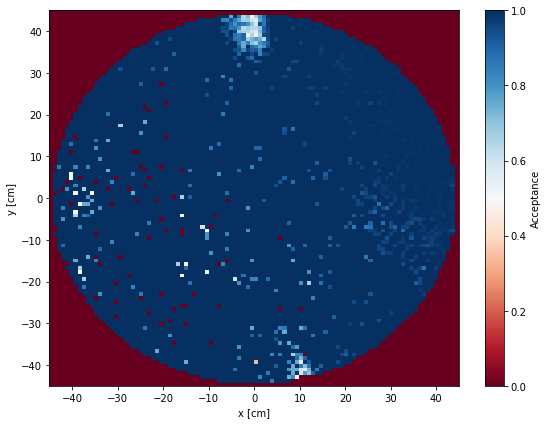

In [103]:
hist_data, x_data, y_data = np.histogram2d(xy_z2_energy['x_3d_nn_tf'], xy_z2_energy['y_3d_nn_tf'], 
                                           bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut, x_cut, y_cut = np.histogram2d(xy_z2_energy_cut['x_3d_nn_tf'], xy_z2_energy_cut['y_3d_nn_tf'], 
                                        bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy = hist_cut/hist_data
plt.figure(figsize=(8,6))
c1 = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


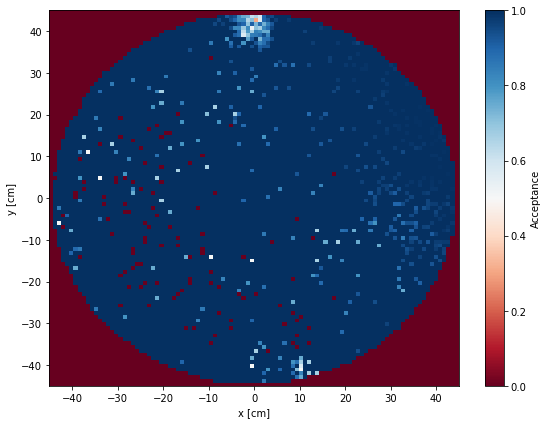

In [104]:
hist_data, x_data, y_data = np.histogram2d(xy_z3_energy['x_3d_nn_tf'], xy_z3_energy['y_3d_nn_tf'], 
                                           bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut, x_cut, y_cut = np.histogram2d(xy_z3_energy_cut['x_3d_nn_tf'], xy_z3_energy_cut['y_3d_nn_tf'], 
                                        bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy = hist_cut/hist_data
plt.figure(figsize=(8,6))
c1 = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

### On all z

Unnamed selection: 4923 rows removed (98.99% passed)
Unnamed selection: 483838 rows removed (1.01% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.5.0-py3.4.egg/hax/cuts.py:130: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


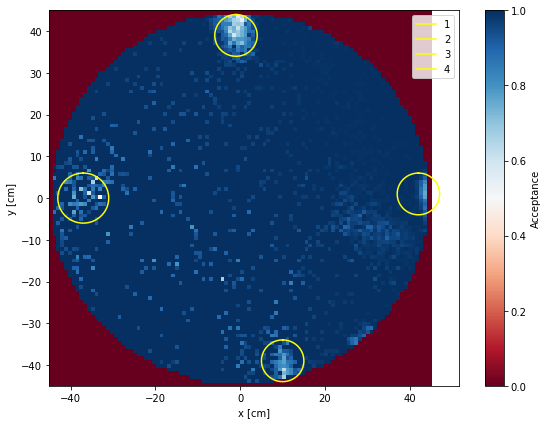

In [154]:
xy_energy = pd.concat([xy_z1_energy, xy_z2_energy, xy_z3_energy])
xy_energy_cut = hax.cuts.selection(xy_energy, xy_energy['cs2_aft_cut_2'] == True)
xy_energy_cut_check = hax.cuts.selection(xy_energy, xy_energy['cs2_aft_cut_2'] == False)

hist_data, x_data, y_data = np.histogram2d(xy_energy['x_3d_nn_tf'], xy_energy['y_3d_nn_tf'], 
                                           bins=(100,100), range=((-45, +45), (-45, +45)))
hist_cut, x_cut, y_cut = np.histogram2d(xy_energy_cut['x_3d_nn_tf'], xy_energy_cut['y_3d_nn_tf'], 
                                        bins=(100,100), range=((-45, +45), (-45, +45)))
Acceptance_xy = hist_cut/hist_data
plt.figure(figsize=(8,6))
c1 = plt.pcolor(x_data, y_data, Acceptance_xy, cmap='RdBu', vmin=0, vmax=1)
plt.colorbar(c1, label='Acceptance')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt_circle(radius=5, xc = -1, yc = 39, label= '1', color='yellow')
plt_circle(radius=5, xc = 10, yc = -39, label= '2', color='yellow')
plt_circle(radius=5, xc = +42, yc = 1, label= '3', color='yellow')
plt_circle(radius=6, xc = -37, yc = 0, label= '4', color='yellow')

plt.tight_layout()

In [155]:
r, xc, yc = 5.0, -1.0, 39.0
circ1 = xy_energy_cut_check[(xy_energy_cut_check['x_3d_nn_tf']-xc)**2 + (xy_energy_cut_check['y_3d_nn_tf']-yc)**2 <= r**2]

r, xc, yc = 5.0, 10.0, -39.0
circ2 = xy_energy_cut_check[(xy_energy_cut_check['x_3d_nn_tf']-xc)**2 + (xy_energy_cut_check['y_3d_nn_tf']-yc)**2 <= r**2]

r, xc, yc = 5.0, 42.0, 1.0
circ3 = xy_energy_cut_check[(xy_energy_cut_check['x_3d_nn_tf']-xc)**2 + (xy_energy_cut_check['y_3d_nn_tf']-yc)**2 <= r**2]

r, xc, yc = 6.0, -37.0, 0.0
circ4 = xy_energy_cut_check[(xy_energy_cut_check['x_3d_nn_tf']-xc)**2 + (xy_energy_cut_check['y_3d_nn_tf']-yc)**2 <= r**2]

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


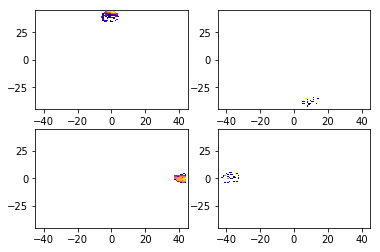

In [158]:
plt.subplot(221)
plt.hist2d(circ1['x_3d_nn_tf'], circ1['y_3d_nn_tf'], 
           bins=(100,100), 
           range=((-45, +45), (-45, +45)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1,label= '1')
plt.legend(loc='best')
plt.subplot(222)
plt.hist2d(circ2['x_3d_nn_tf'], circ2['y_3d_nn_tf'], 
           bins=(100,100), 
           range=((-45, +45), (-45, +45)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '2') 
plt.legend(loc='best')
plt.subplot(223)
plt.hist2d(circ3['x_3d_nn_tf'], circ3['y_3d_nn_tf'], 
           bins=(100,100), 
           range=((-45, +45), (-45, +45)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '3')
plt.legend(loc='best')
plt.subplot(224)
plt.hist2d(circ4['x_3d_nn_tf'], circ4['y_3d_nn_tf'], 
           bins=(100,100), 
           range=((-45, +45), (-45, +45)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '4')
plt.legend(loc='best')
plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


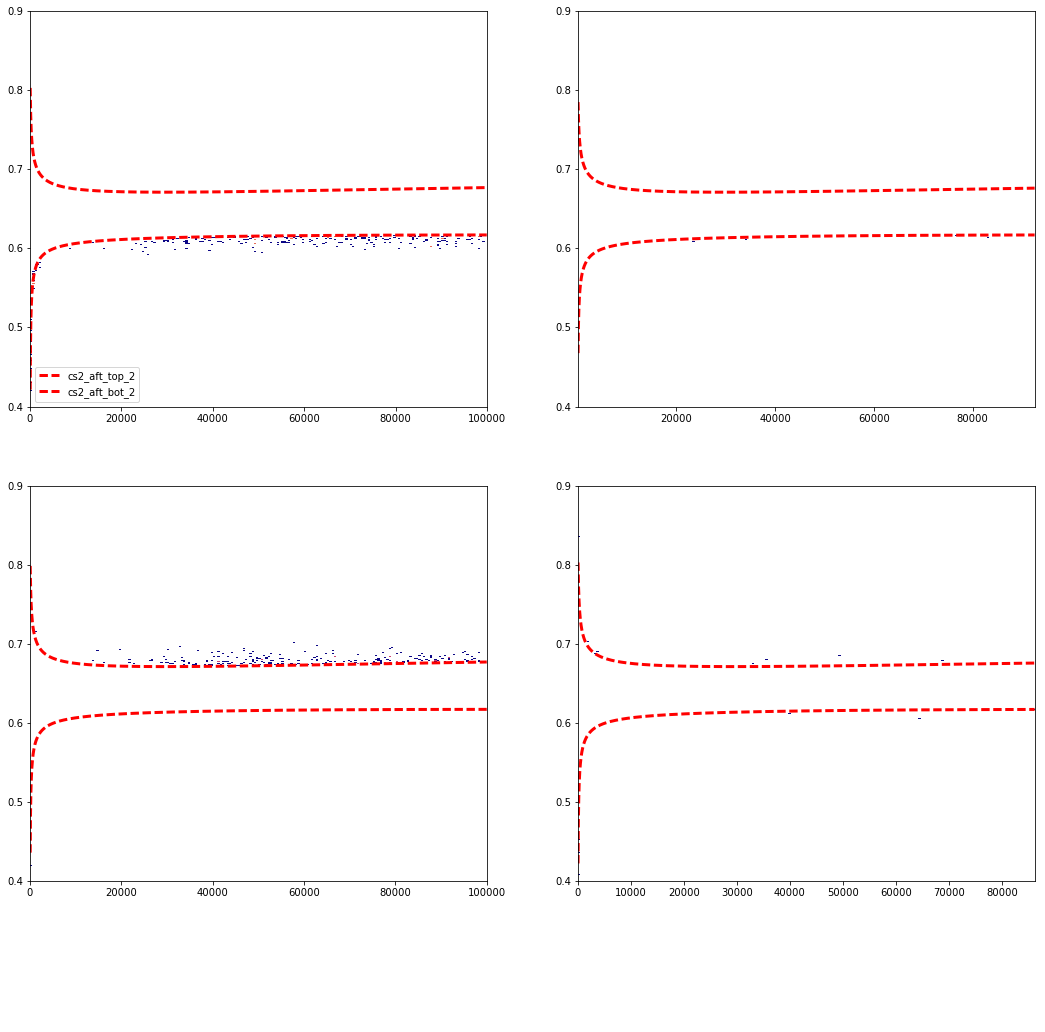

In [159]:
plt.figure(figsize=(18,16))
plt.subplot(221)
plt.hist2d(circ1['s2'], 
           circ1['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '1')
plt.plot(DF_cs2_aft_top_2.s2.iloc[10:], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:], 
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')
plt.ylim(0.4, 0.9)

plt.subplot(222)
plt.hist2d(circ2['s2'], 
           circ2['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '2')
plt.plot(DF_cs2_aft_top_2.s2.iloc[10:], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:], 
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')
plt.ylim(0.4, 0.9)

plt.subplot(223)
plt.hist2d(circ3['s2'], 
           circ3['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '3')
plt.plot(DF_cs2_aft_top_2.s2.iloc[10:], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:], 
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')
plt.ylim(0.4, 0.9)

plt.subplot(224)
plt.hist2d(circ4['s2'], 
           circ4['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '4')
plt.plot(DF_cs2_aft_top_2.s2.iloc[10:], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:], 
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')
plt.ylim(0.4, 0.9)

plt.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


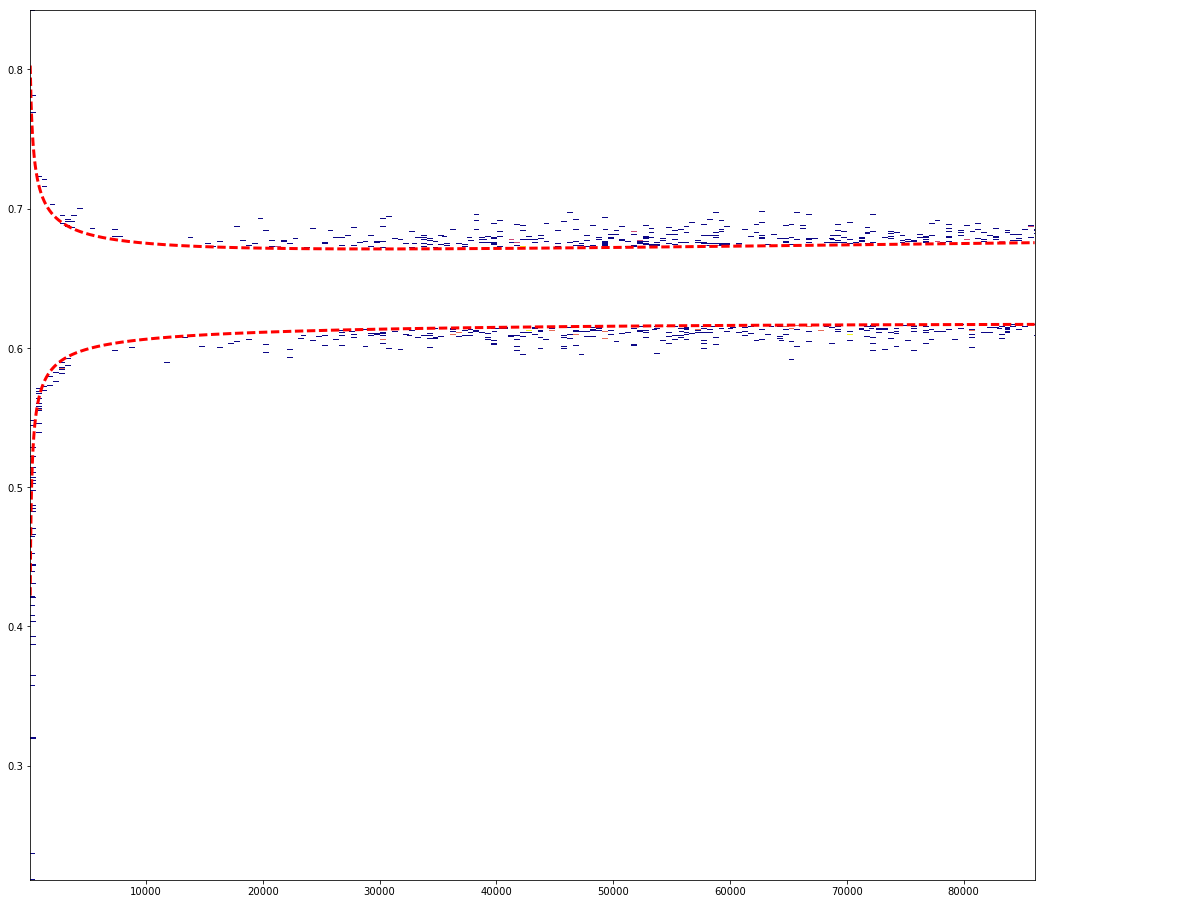

In [161]:
plt.figure(figsize=(18,16))
plt.hist2d(circ1['s2'], 
           circ1['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '1')
plt.hist2d(circ2['s2'], 
           circ2['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '2')
plt.hist2d(circ3['s2'], 
           circ3['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '3')
plt.hist2d(circ4['s2'], 
           circ4['cs2_aft_nn_tf'], 
           bins=(200,1000), 
           #range=((0, 3e5), (0.4,0.8)), 
           cmap=plt.cm.plasma, norm=matplotlib.colors.LogNorm(),
           cmin = 1,alpha = 1, label= '4')

plt.plot(DF_cs2_aft_top_2.s2.iloc[10:], DF_cs2_aft_top_2.cs2_aft_top_2.iloc[10:], 
         linestyle='--', linewidth=3.0, color='red')
plt.plot(DF_cs2_aft_bot_2.s2.iloc[10:], DF_cs2_aft_bot_2.cs2_aft_bot_2.iloc[10:],
         linestyle='--', linewidth=3.0, color='red')